In [1]:
# python 3.8 tensorflow 2.10 opencv-contrib-python 4.9.0 scikit-learn 1.2.0   

import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import zipfile
import os

In [6]:
# zip 파일 경로와 해제할 디렉토리 경로
zip_file_path = './Images.zip'
extract_to_directory = './image_data'

# zip 파일 열고 모든 파일을 지정된 디렉토리에 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

# zip 파일 경로와 해제할 디렉토리 경로
zip_file_path2 = 'Airplanes_Annotations.zip'
extract_to_directory2 = 'annotations'

# zip 파일 열고 모든 파일을 지정된 디렉토리에 해제
with zipfile.ZipFile(zip_file_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory2)

In [7]:
path = "./image_data/Images/"
annot = "./annotations/Airplanes_Annotations"

42845.jpg


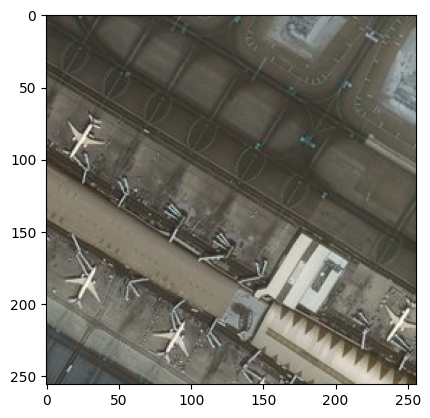

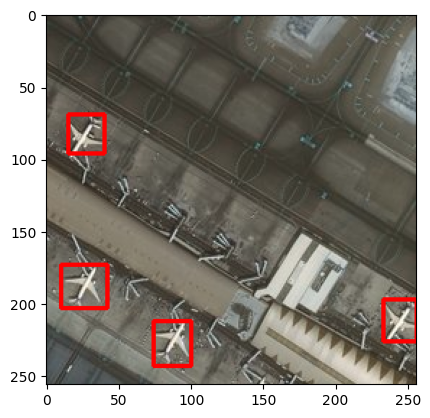

In [8]:
# 바운딩 박스 표시

for i in os.listdir(annot):
    filename = i.split(".")[0]+".jpg"
    print(filename)
    img = cv2.imread(os.path.join(path,filename))
    df = pd.read_csv(os.path.join(annot,i))
    plt.imshow(img)
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
    plt.figure()
    plt.imshow(img)
    break

In [9]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

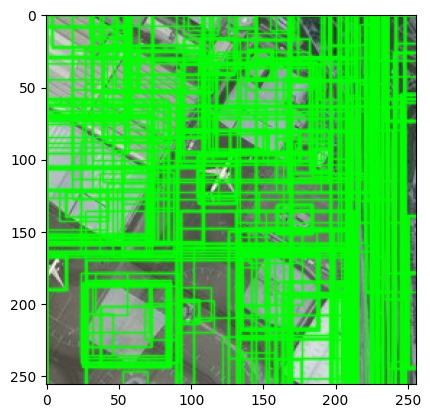

In [10]:
# 42850.jpg 이미지 예시

im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im) # selective search에 input
ss.switchToSelectiveSearchFast() # selective search 빠른 모드로 전환
rects = ss.process() # 설정된 이미지에서 선택적 검색을 실행하여 후보 영역(rectangles)을 찾는 것. 반환된 rects는 각 후보 영역의 좌표와 크기 정보를 담음.
imOut = im.copy() # 원본 이미지를 복사하여 imOut 변수에 저장, 원본 이미지 변경하지 않기 위해
for i, rect in (enumerate(rects)):
    x, y, w, h = rect # 후보영역 좌표와 너비 높이
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1) # (0, 255, 0)은 사각형의 색상(BGR 포맷, 여기서는 녹색)을 나타냄. 1은 사각형 두께
plt.imshow(imOut)

In [11]:
# IOU 정의하기
# IOU(Intersection over Union)는 물체의 위치를 나타내는 bounding box가 얼마나 일치하는지를 수학적으로 나타내는 지표
# 실제 물체의 위치와 예측 물체의 위치를 평가

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top) # 교집합

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # 교집합 / 합집합
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area) 
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [13]:
# train img, label 구분

train_images=[]
train_labels=[]

for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h}) # iou 지표 받기
                        if counter < 30: # 하나의 이미지에 많은 배경 샘플과 Object 샘플이 있을 수 있으므로 Object와 배경의 비율을 비슷하게 맞추기 위해 counter와 falsecounter의 값을 30으로 제안하여 region proposal을 설정
                            if iou > 0.70: # iou 값을 기준으로 0.7 초과이면 그 region을 Object 즉, 비행기의 라벨인 1로 라벨링하게 하고 region 이미지의 크기를 resize해 전부 같게 만듦
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3: # 반대로 iou 값을 기준으로 0.3 미만이면 그 region을 배경 즉, 라벨이 0으로 라벨링하게 하고 region 이미지의 크기를 resize해 전부 같게 만듦
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

17 airplane_001.jpg
inside
18 airplane_002.jpg
19 airplane_003.jpg
20 airplane_004.jpg
inside
21 airplane_005.jpg
inside
22 airplane_006.jpg
23 airplane_007.jpg
inside
24 airplane_008.jpg
25 airplane_009.jpg
26 airplane_010.jpg
27 airplane_011.jpg
28 airplane_012.jpg
inside
29 airplane_013.jpg
30 airplane_014.jpg
31 airplane_015.jpg
32 airplane_016.jpg
33 airplane_017.jpg
34 airplane_018.jpg
35 airplane_019.jpg
36 airplane_020.jpg
37 airplane_021.jpg
38 airplane_022.jpg
39 airplane_023.jpg
40 airplane_024.jpg
41 airplane_025.jpg
42 airplane_026.jpg
43 airplane_027.jpg
44 airplane_028.jpg
45 airplane_029.jpg
46 airplane_030.jpg
47 airplane_031.jpg
48 airplane_032.jpg
49 airplane_033.jpg
50 airplane_034.jpg
51 airplane_035.jpg
52 airplane_036.jpg
53 airplane_037.jpg
54 airplane_038.jpg
55 airplane_039.jpg
56 airplane_040.jpg
57 airplane_041.jpg
inside
58 airplane_042.jpg
59 airplane_043.jpg
60 airplane_044.jpg
61 airplane_045.jpg
inside
62 airplane_046.jpg
63 airplane_047.jpg
64 airplane

In [14]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [15]:
X_new.shape

(30229, 224, 224, 3)

In [4]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [5]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [17]:
X= vggmodel.layers[-2].output

In [18]:
predictions = Dense(2, activation="softmax")(X)

In [19]:
model_final = Model(vggmodel.input, predictions)

In [20]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

In [21]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [22]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [24]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [25]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [26]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [27]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(27206, 224, 224, 3) (3023, 224, 224, 3) (27206, 2) (3023, 2)


In [28]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [30]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [35]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22368\3734971591.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


Epoch 1/1000
10/10 [==============================] - ETA: 0s - loss: 0.9581 - accuracy: 0.7469
Epoch 1: val_loss improved from inf to 0.45836, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 34s 2s/step - loss: 0.9581 - accuracy: 0.7469 - val_loss: 0.4584 - val_accuracy: 0.7969
Epoch 2/1000
10/10 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.8344
Epoch 2: val_loss improved from 0.45836 to 0.23248, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 29s 3s/step - loss: 0.4257 - accuracy: 0.8344 - val_loss: 0.2325 - val_accuracy: 0.8438
Epoch 3/1000
10/10 [==============================] - ETA: 0s - loss: 0.2919 - accuracy: 0.8875
Epoch 3: val_loss improved from 0.23248 to 0.18710, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 20s 2s/step - loss: 0.2919 - accuracy: 0.8875 - val_loss: 0.1871 - val_accuracy: 0.9062
Epoch 4/1000
10/10 [==============================] - ETA: 0s - l

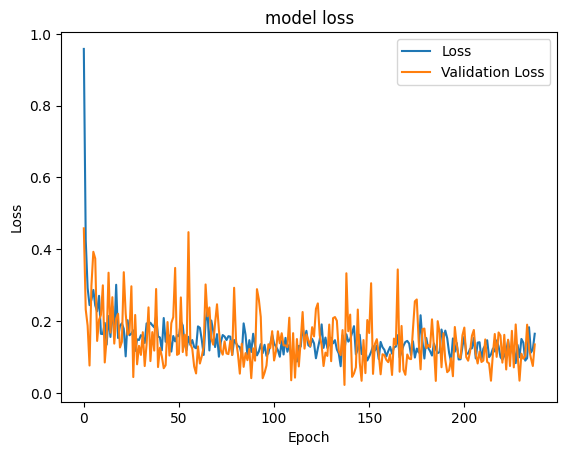

<Figure size 640x480 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

1/1 [==============================] - 1s 718ms/step
not plane


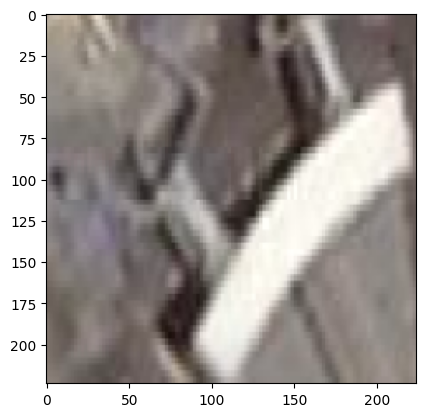

In [37]:
im = X_test[1600]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

1/1 [==============================] - 0s 15ms/step


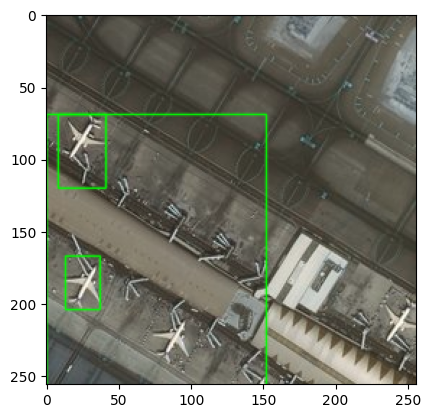

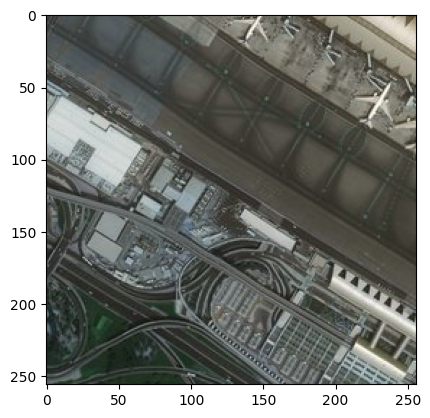

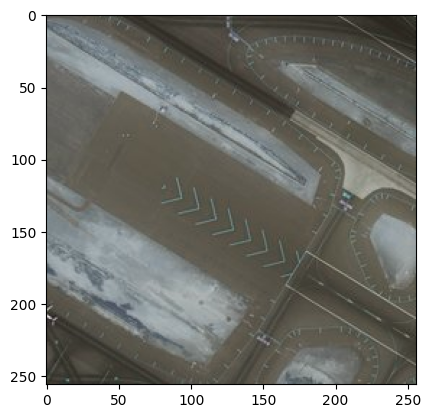

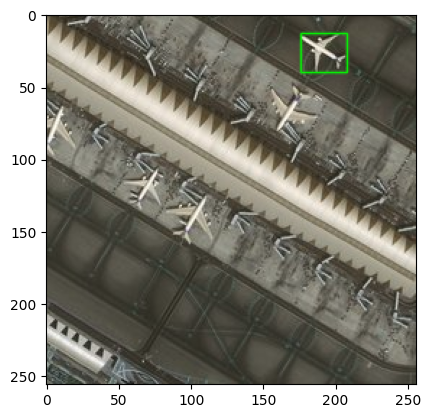

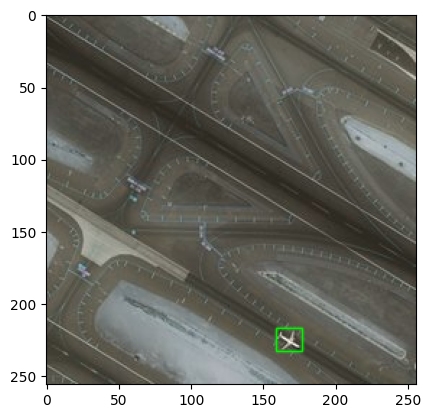

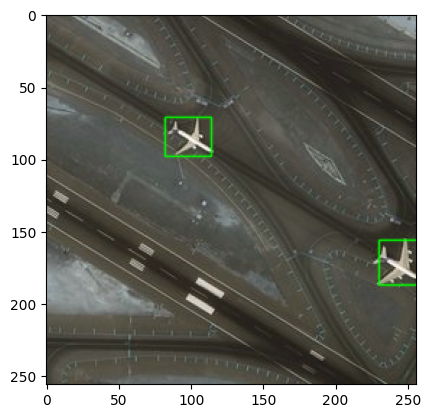

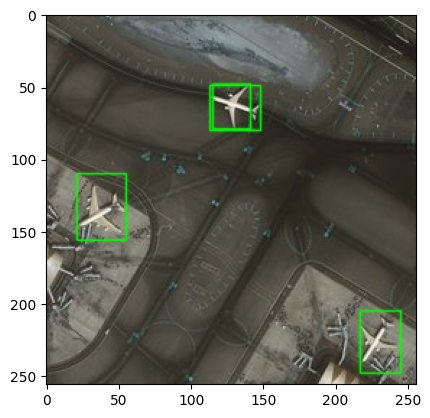

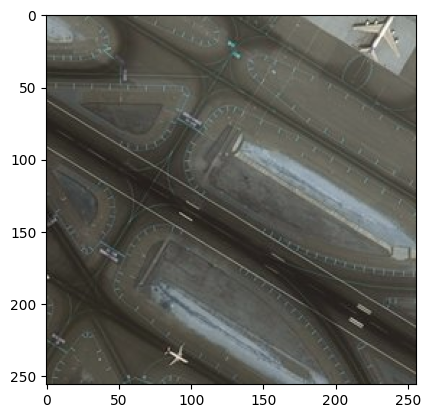

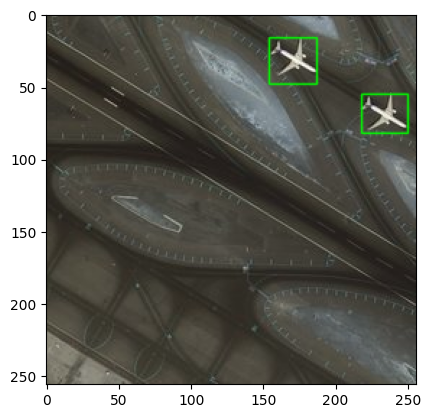

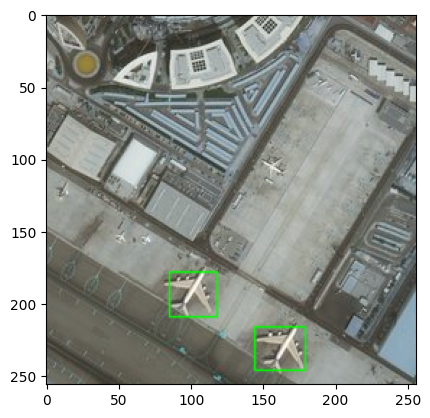

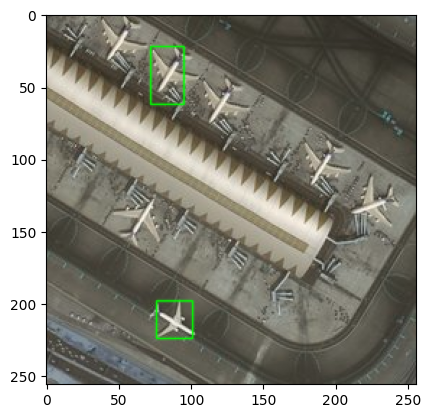

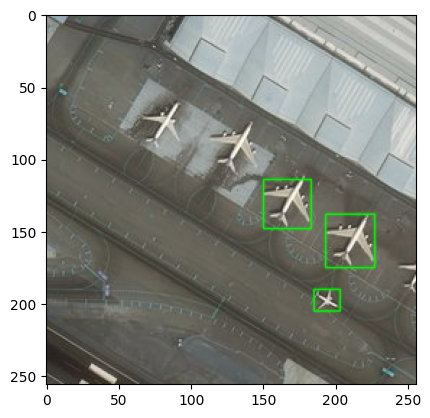

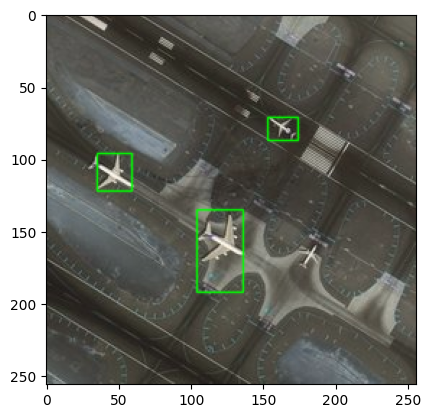

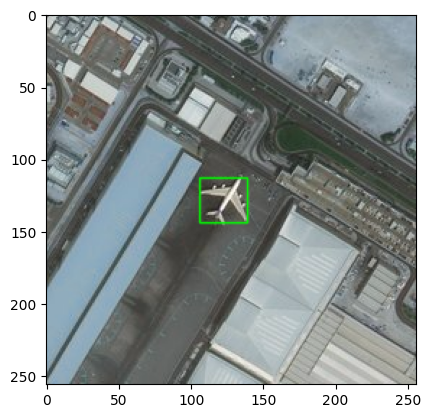

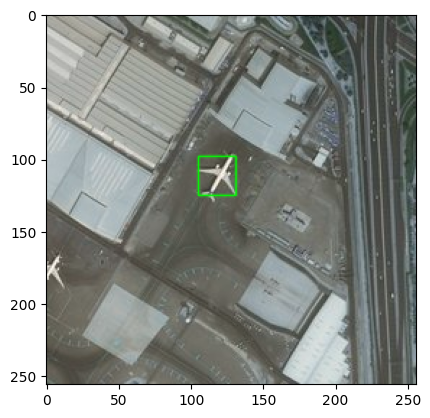

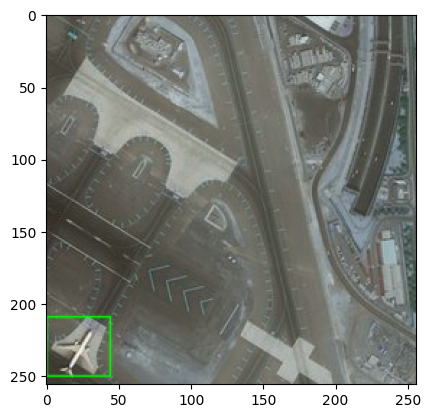

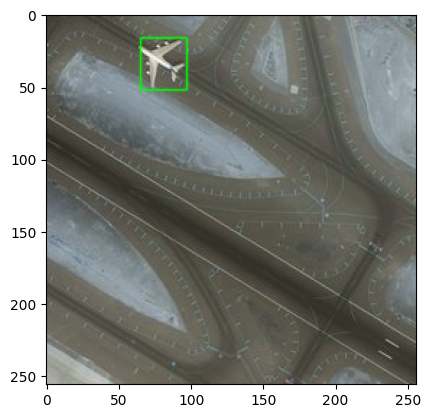

In [38]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)